In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import load_model

df = pd.read_csv('residentialRevenue.csv',index_col='Date',parse_dates=True)
print(df)

            residentialRevenue
Date                          
1990-01-31             6841300
1990-02-28             5571807
1990-03-31             5442934
1990-04-30             5015134
1990-05-31             5006417
...                        ...
2020-04-30            12947196
2020-05-31            13866500
2020-06-30            17424654
2020-07-31            22123951
2020-08-31            21145130

[368 rows x 1 columns]


In [102]:
# df = pd.read_csv('AK.csv',index_col='date',parse_dates=True)
df.index.freq='M'

In [103]:
df.head()

,residentialRevenue
Date,
1990-01-31,6841300
1990-02-28,5571807
1990-03-31,5442934
1990-04-30,5015134
1990-05-31,5006417


<AxesSubplot:xlabel='Date'>

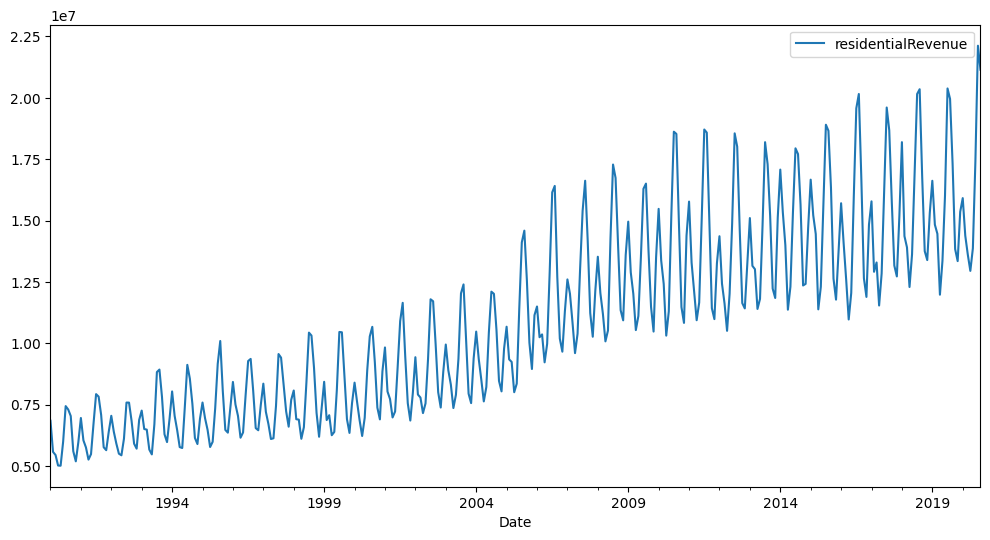

In [104]:
df.plot(figsize=(12,6))

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose

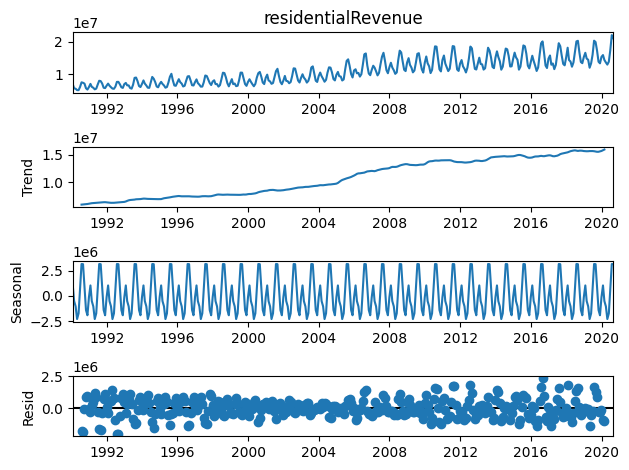

In [106]:
results = seasonal_decompose(df["residentialRevenue"])
results.plot();

In [107]:
len(df)

368

In [108]:
train = df.iloc[:300]
test = df.iloc[300:]

In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [110]:
df.head(),df.tail()

(            residentialRevenue
 Date                          
 1990-01-31             6841300
 1990-02-28             5571807
 1990-03-31             5442934
 1990-04-30             5015134
 1990-05-31             5006417,
             residentialRevenue
 Date                          
 2020-04-30            12947196
 2020-05-31            13866500
 2020-06-30            17424654
 2020-07-31            22123951
 2020-08-31            21145130)

In [111]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [112]:
scaled_train[:10]
print(df.dtypes)

residentialRevenue    int64
dtype: object


In [113]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [114]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [115]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.13390506 0.04126071 0.03185589 0.00063614 0.         0.0714879
 0.17732919 0.16715811 0.14781602 0.04306917 0.01299546 0.07021211]
Predict this y: 
 [[0.14197192]]


In [116]:
X.shape

(1, 12, 1)

In [117]:

n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [118]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [119]:
# define model

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200, activation='relu',input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [120]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 200)           161600    
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [121]:
# fit model
model.fit(generator,epochs=45)

Epoch 1/45
288/288 [==============================] - 3s 6ms/step - loss: 0.0268
Epoch 2/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0185
Epoch 3/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0110
Epoch 4/45
288/288 [==============================] - 2s 5ms/step - loss: 0.0054
Epoch 5/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0039
Epoch 6/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0036
Epoch 7/45
288/288 [==============================] - 2s 5ms/step - loss: 0.0035
Epoch 8/45
288/288 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 9/45
288/288 [==============================] - 2s 5ms/step - loss: 0.0034
Epoch 10/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 11/45
288/288 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 12/45
288/288 [==============================] - 2s 5ms/step - loss: 0.0030
Epoch 13/45
288/288 [====

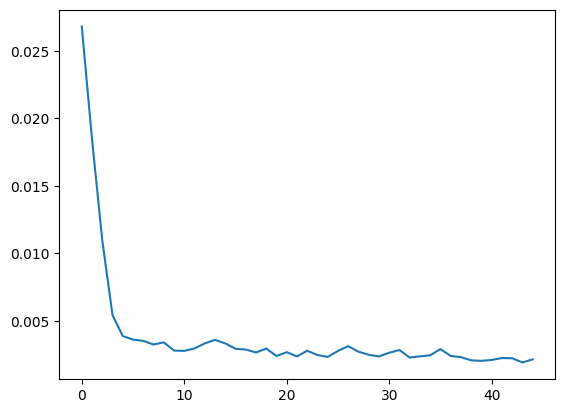

In [122]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [123]:
last_train_batch = scaled_train[-12:]

In [124]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [125]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 179ms/step


array([[0.88626623]], dtype=float32)

In [126]:
scaled_test[0]

array([0.85084046])

In [127]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [128]:
test_predictions

[array([0.88626623], dtype=float32),
 array([0.8137818], dtype=float32),
 array([0.6828636], dtype=float32),
 array([0.509762], dtype=float32),
 array([0.5578825], dtype=float32),
 array([0.77377146], dtype=float32),
 array([0.94460595], dtype=float32),
 array([0.92247975], dtype=float32),
 array([0.7959092], dtype=float32),
 array([0.5755125], dtype=float32),
 array([0.5623268], dtype=float32),
 array([0.7304895], dtype=float32),
 array([0.89439565], dtype=float32),
 array([0.84927636], dtype=float32),
 array([0.7121259], dtype=float32),
 array([0.5468943], dtype=float32),
 array([0.5831739], dtype=float32),
 array([0.7880187], dtype=float32),
 array([0.9405014], dtype=float32),
 array([0.9173599], dtype=float32),
 array([0.808968], dtype=float32),
 array([0.6128524], dtype=float32),
 array([0.58522034], dtype=float32),
 array([0.7458701], dtype=float32),
 array([0.9001269], dtype=float32),
 array([0.87008446], dtype=float32),
 array([0.73946047], dtype=float32),
 array([0.58035064], 

In [129]:
test.head()

,residentialRevenue
Date,
2015-01-31,16665369
2015-02-28,15214671
2015-03-31,14449846
2015-04-30,11379471
2015-05-31,12300264


In [130]:
true_predictions = scaler.inverse_transform(test_predictions)

In [131]:
test['Predictions'] = true_predictions

C:\Users\kasun\AppData\Local\Temp\ipykernel_38620\2515899287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

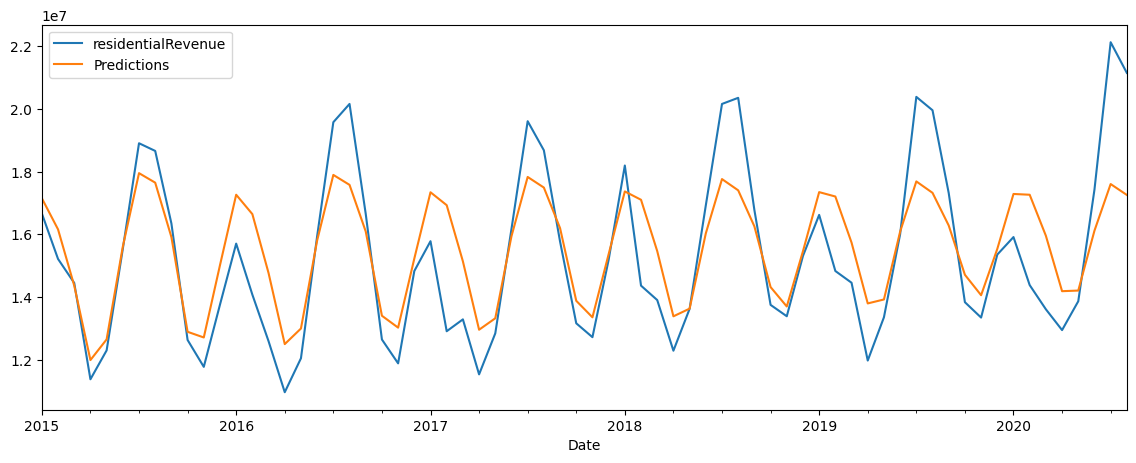

In [132]:
test.plot(figsize=(14,5))

In [133]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(test['residentialRevenue'],test['Predictions']))
mse = mean_squared_error(test['residentialRevenue'],test['Predictions'])
r2 = r2_score(test['residentialRevenue'],test['Predictions'])

print("R-squared:", r2)
print(rmse)
print(mse)

mape = np.mean(np.abs((test['residentialRevenue'] -test['Predictions'])  / test['residentialRevenue'])) * 100

print("Mean Absolute Percentage Error:", mape)
actual_mean = test['residentialRevenue'].mean()
accuracy = (1 - rmse / actual_mean) * 100
print(f"The accuracy of the model is {accuracy:.2f}%")

R-squared: 0.6513798961661099
1606554.455827375
2581017219538.793
Mean Absolute Percentage Error: 8.067655367707632
The accuracy of the model is 89.50%


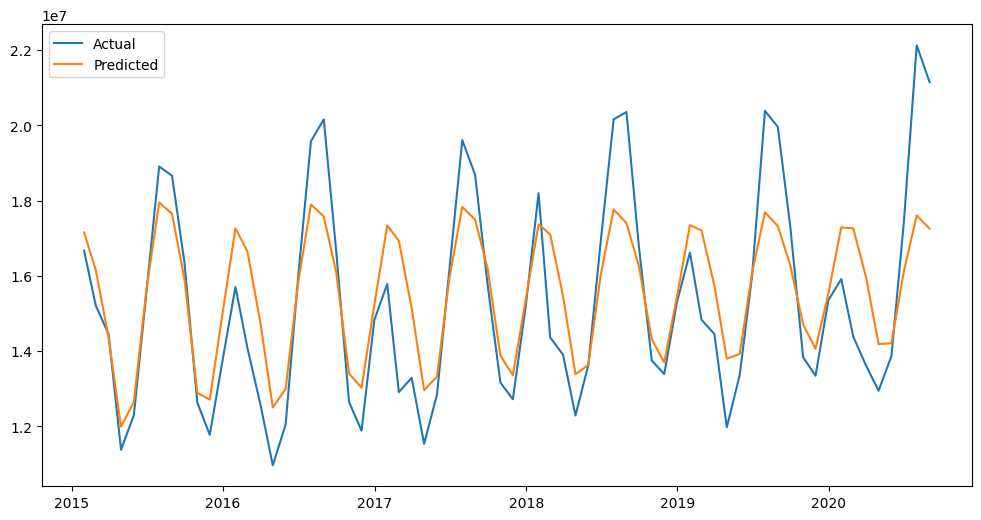

In [134]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test['residentialRevenue'], label='Actual')
plt.plot(test.index, test['Predictions'], label='Predicted')
plt.legend()
plt.show()


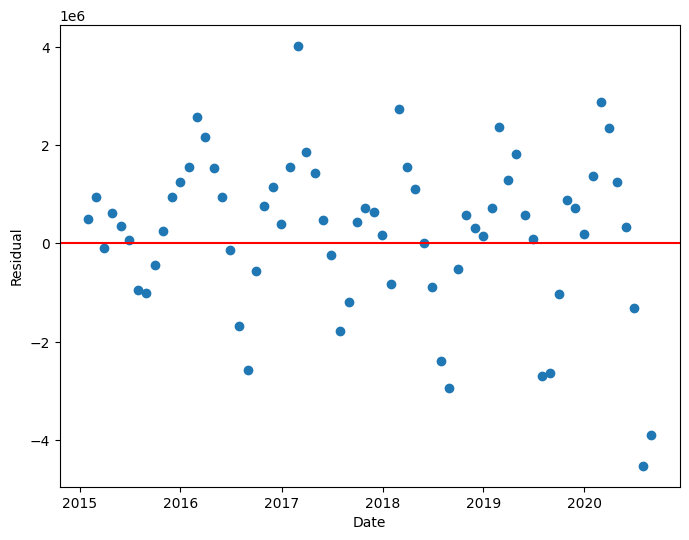

In [135]:
residuals = test['Predictions'] - test['residentialRevenue']
plt.figure(figsize=(8,6))
plt.scatter(test.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()


In [136]:
# save the model to disk
model.save('RR_Model.h5')


In [137]:
from tensorflow.python.keras.models import model_from_json

# Save the model's architecture as a JSON file
model_json = model.to_json()
with open("model_RR.json", "w") as json_file:
    json_file.write(model_json)

# Save the model's weights as an HDF5 file
model.save_weights("model_weights_RR.h5")

# Load the model's architecture from the JSON file
with open('model_RR.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("model_weights_RR.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')


In [148]:
import numpy as np
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
# Load the model's architecture from the JSON file
with open('model_RR.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("model_weights_RR.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')

# Define the 12 past month values
past_data = [31339465,32216079,28354187,29965163,27469754,30176368,35585347,40269224,39320309,34929664,31157491,29139490,31739196]
# Reshape the example data into a 2D array with one column
example_data = np.array(past_data).reshape(-1, 1)
# create the scaler object
scaler = MinMaxScaler()

# fit the scaler object on the training data
scaler.fit(example_data)

# transform the training and testing data using the fitted scaler
scaled_test = scaler.transform(example_data)


# Generate a sequence of input data for the model to make a prediction on
n_input = 12
generator = TimeseriesGenerator(scaled_test, scaled_test, length=12, batch_size=1)
# Get the input sequence for the first batch
X, y = generator[0]

# Reshape the data to match the input shape of the model
X = X.reshape((1, 12, 1))

# Make a prediction using the loaded model
prediction = loaded_model.predict(X)

# Inverse transform the prediction to get the actual scale
actual_prediction = scaler.inverse_transform(prediction)

print("Prediction:", actual_prediction[0][0])


1/1 [==============================] - 0s 163ms/step
Prediction: 31525194.0


In [149]:
import numpy as np
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

# Load the model's architecture from the JSON file
with open('model_RR.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("model_weights_RR.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')

# Define the past month values for which we want to make a prediction
past_data = [31339465, 32216079, 28354187, 29965163, 27469754, 30176368, 35585347, 40269224, 39320309, 34929664, 31157491, 29139490, 31739196]

# Reshape the example data into a 2D array with one column
example_data = np.array(past_data).reshape(-1, 1)

# Create a MinMaxScaler object to scale the data between 0 and 1
scaler = MinMaxScaler()

# Fit the scaler object on the example data
scaler.fit(example_data)

# Transform the example data using the fitted scaler
scaled_example_data = scaler.transform(example_data)

# Generate a sequence of input data for the model to make a prediction on
n_input = 12
generator = TimeseriesGenerator(scaled_example_data, scaled_example_data, length=n_input, batch_size=1)

# Get the input sequence for the first batch
X, y = generator[0]

# Reshape the data to match the input shape of the model
X = X.reshape((1, n_input, 1))

# Make a prediction using the loaded model
prediction = loaded_model.predict(X)

# Inverse transform the prediction to get the actual scale
actual_prediction = scaler.inverse_transform(prediction)

# Print the predicted value
print("Prediction:", actual_prediction[0][0])


1/1 [==============================] - 0s 166ms/step
Prediction: 31525194.0


In [138]:
import numpy as np
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd

# Load the model's architecture from the JSON file
with open('model_RR.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("model_weights_RR.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')

# Load the data from a CSV file
data = pd.read_csv("residentialRevenue.csv")

# Extract the last 12 months of data from the DataFrame
last_12_months = data.tail(13)["residentialRevenue"].tolist()

# Reshape the data into a 2D array with one column
data_array = np.array(last_12_months).reshape(-1, 1)

# Create a MinMaxScaler object to scale the data between 0 and 1
scaler = MinMaxScaler()

# Fit the scaler object on the data
scaler.fit(data_array)

# Transform the data using the fitted scaler
scaled_data = scaler.transform(data_array)

# Generate a sequence of input data for the model to make a prediction on
n_input = 12
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

# Get the input sequence for the first batch
X, y = generator[0]

# Reshape the data to match the input shape of the model
X = X.reshape((1, n_input, 1))

# Make a prediction using the loaded model
prediction = loaded_model.predict(X)

# Inverse transform the prediction to get the actual scale
actual_prediction = scaler.inverse_transform(prediction)

# Print the predicted value
print("Prediction:", actual_prediction[0][0])
# 2020-08-01,40421937

1/1 [==============================] - 0s 159ms/step
Prediction: 21337278.0
